<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - LDA
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Load required packages and the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import sys
import pandas as pd
import numpy as np
from pprint import pprint

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy (for lemmatization)
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)

# Regression and smoothing tools
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# Enable logging for gensim (optional)
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

C:\Users\Hallk\AppData\Roaming\Python\Python37\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Define a function to read in the fully preprocessed data
def read_preprocessed(language, tokenize = True):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/"+language+"_preprocessed.csv"

    # Read in the dataframe containing the text data
    tx_pp = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_pp.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Reduce the dataframe to a list containing the text data
    tx_pp = tx_pp.tx.to_list()

    # Tokenize the data again if tokenize = True (RAM-saving)
    if tokenize:
        tx_pp = retokenize(tx_pp)

    # Return the preprocessed data
    return tx_pp, idx

# Define a function to retokenize the preprocessed text data (RAM-saving)
def retokenize(article_list):
    for i in range(len(article_list)):
        temp_tx = str(article_list[i]).split()
        article_list[i] = temp_tx
    return article_list

In [4]:
# Define a function to read in the preprocessed fulltext data
def read_preprocessed_fulltext(language):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/Fulltext/"+language+"_fulltext.csv"

    # Read in the data
    tx_ft = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_ft.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Extract the text data as a list of articles
    tx_ft = tx_ft.tx.to_list()

    # Return the preprocessed data
    return tx_ft, idx

In [5]:
# Read in the preprocessed data
it_tx, it_idx = read_preprocessed('it')

# Take a look at the size of the precleaned data
sys.getsizeof(it_tx)

189032

In [6]:
# Take a look at the preprocessed data
it_tx[0][:6]

['fermati', 'obbligare', 'oppresso', 'ginocchio', 'applaudivamo', 'stadio']

In [7]:
# Take a look at the dataframe containing the according index
it_idx.tail(3)

,it_idx
23618,2425113
23619,2425114
23620,2425115


In [8]:
# Retrieve the location of the article in the preprocessed data using the according article id
article_ids = [2425114, 2425115]
location = it_idx[it_idx.it_idx.isin(article_ids)].index.tolist() #23619

# Access the preprocessed text from the articles with the article ids in [2425114, 2425115]
#list(it_tx[i] for i in location)

# Look at the according location of the articles with the article ids in [2425114, 2425115]
location

[23619, 23620]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 2. Create the Dictionary and Corpus needed for Topic Modeling</h2>
</div>

The two main inputs to the LDA topic model are the dictionary and the corpus. So let's create them subsequently

In [9]:
# Create Dictionary
dictionary = corpora.Dictionary(it_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 80% of the articles are considered, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(it_tx)/100), no_above = 0.8, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

1644

In [10]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in it_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]]


In [11]:
# Remove unnecessary variables to save RAM
del it_tx

Note: 

- Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
- In order to observe the word that corresponds to a given id, pass the id as a key to the dictionary.

In [12]:
# Get the phrase corresponding to id 0
dictionary[0]

'amore'

In [13]:
# Get a human readable format of the corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('amore', 1),
  ('bellezza', 1),
  ('camminare', 1),
  ('cantare', 1),
  ('colpa', 1),
  ('compiere', 1),
  ('contatto', 1),
  ('coronavirus', 1),
  ('esperto', 1),
  ('fonte', 1),
  ('maestro', 1),
  ('mano', 1),
  ('medico', 1),
  ('naturale', 1),
  ('obbligare', 1),
  ('perdere', 1),
  ('pieno', 1),
  ('ricco', 1),
  ('rispondere', 1),
  ('seme', 1),
  ('solo', 1),
  ('stringere', 1),
  ('tornare', 1),
  ('tornire', 1),
  ('unico', 1),
  ('vento', 1),
  ('verità', 1),
  ('vincere', 1)]]

In [14]:
# Search for a specific word (here: coronavirus & covid) in the preprocessed dictionary
for i in range(len(dictionary)):
    if dictionary[i] == 'coronavirus':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break
for i in range(len(dictionary)):
    if dictionary[i] == 'covid':
        print('At pos. '+str(i)+' we find the word '+dictionary[i])
        break   

At pos. 7 we find the word coronavirus
At pos. 465 we find the word covid


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 3. Building the Topic Model</h2>
</div>

Now we have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics K and several further hyperparameters as well. To choose the hyperparameters other than the number of topics and the number of passes, we rely on the suggestions given either by Hoffman, Bach & Blei (2010) (for workers, chunksize, offset, decay and eval_every) or by the default settings of the model (for alpha, eta and minimum_probability). The parameter "passes" is chosen such that the model can be trained reasonably and in feasible amount of time. The random state to generate the initial model parameters is set to 7.

Parameters overview:

- workers: number of cpu cores to use for computation (optimal performance if it is set to # of REAL cores - 1)
- num_topics: number of topics to distinguish
- passes: total number of training passes (comparable to epochs in ANN)
- alpha: a 1D array of length equal to the number of expected topics that expresses our a-priori belief on each topic probability (default = 'symmetric' $\rightarrow$ corresponds to 1/num_topics)
- eta: a-priori belief on word probability (either overall or topic specific) (default = None $\rightarrow$ corresponds 1/num_words for all topics)
- minimum_probability: topics with a probability lower than this threshold will be filtered out
- offset: corresponds to $\tau_0$ in Hoffman, Bach & Blei (2010) (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- decay: corresponds to $\kappa$ in Hoffman, Bach & Blei (2010). It should be chosen such that $\kappa \in (0.5,1]$ to guarantee convergence. (chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- eval_every: The performance of the model (measured using the log-perplexity) is estimated every eval_every updates. It corresponds to the batchsize in Hoffman, Bach & Blei (2010) (approximately chosen according to the identified "Best parameter settings for Wikipedia corpus" in said paper)
- chunksize: number of documents to be used in each training chunk (corresponds to batchsize/workers)

In [15]:
# Build LDA model paralellized
t = time.time()
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                    id2word             = dictionary,
                                                    workers             = 5,
                                                    num_topics          = 15,
                                                    chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                    passes              = 12, 
                                                    alpha               = 'symmetric',
                                                    eta                 = None,
                                                    minimum_probability = 0.01,
                                                    offset              = 64,
                                                    decay               = 0.5,
                                                    eval_every          = 4095,
                                                    random_state        = 7,
                                                    per_word_topics     = True)
print("Processing time to build the LDA model paralellized: ", str((time.time() - t)/60), "minutes")

Processing time to build the LDA model paralellized:  1.0131478428840637 minutes


In [16]:
# Save the model to harddisk
lda_model.save("LDA/it_lda_model_"+str(lda_model.num_topics)+"_topics")

In [17]:
# Delete unnecessary variables (stored as modelname.id2word)
del dictionary

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 4. View the topics in the LDA model</h2>
</div>

The above LDA model is built with a predetermined number of distingushied topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. Thus, we can visualize the keywords for each topic and the weightage (importance) of each keyword as follows.

In [5]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/it_lda_model_15_topics")         # adjust the digit appropriately

In [6]:
# Print the 10 most important keywords for each topic
pprint(lda_model.print_topics())

[(0,
  '0.029*"politico" + 0.024*"attualità" + 0.020*"presidente" + 0.014*"trump" + '
  '0.012*"treno" + 0.011*"keystone" + 0.011*"uniti" + 0.010*"aereo" + '
  '0.009*"lugano" + 0.008*"americano"'),
 (1,
  '0.019*"lugano" + 0.017*"punto" + 0.014*"keystone" + 0.011*"partito" + '
  '0.011*"gara" + 0.010*"classificare" + 0.009*"match" + 0.009*"ultimo" + '
  '0.009*"bianconero" + 0.009*"league"'),
 (2,
  '0.020*"lugano" + 0.015*"locarno" + 0.015*"evento" + 0.012*"festival" + '
  '0.011*"edizione" + 0.011*"sabato" + 0.009*"museo" + 0.009*"bellinzona" + '
  '0.009*"arte" + 0.008*"ch"'),
 (3,
  '0.021*"lugano" + 0.016*"stagione" + 0.016*"giocare" + 0.015*"giocatore" + '
  '0.015*"squadrare" + 0.012*"club" + 0.010*"sport" + 0.010*"partito" + '
  '0.010*"ambrì" + 0.010*"è"'),
 (4,
  '0.012*"nuovo" + 0.010*"cliente" + 0.009*"elettrico" + 0.008*"online" + '
  '0.008*"ch" + 0.008*"offrire" + 0.007*"auto" + 0.007*"utilizzare" + '
  '0.007*"sistemare" + 0.007*"prezzo"'),
 (5,
  '0.018*"covid" + 0.01

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 5. Compute Model Perplexity and Coherence Score</h2>
</div>

Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) (as explained in Röder, Both & Hinneburg (2015)) provide a convenient measure to judge how good a given topic model is. (Experience has shown that topic coherence score, in particular, has been more helpful)

In [7]:
# Load a pretrained model from disk (adjust the digit appropriately!!!)
lda_model = gensim.models.ldamodel.LdaModel.load("LDA/it_lda_model_15_topics")         # adjust the digit appropriately

In [8]:
# Read in the preprocessed data
it_tx, it_idx = read_preprocessed('it')

In [9]:
# Create the corpus again
corpus = [lda_model.id2word.doc2bow(article) for article in it_tx]

In [10]:
# Compute Perplexity
print('Perplexity of the LDA model with', str(lda_model.num_topics), 'topics:', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

Perplexity of the LDA model with 15 topics: -6.8177551969933265


In [11]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = it_tx, dictionary = lda_model.id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score of the LDA model with', str(lda_model.num_topics), 'topics:', coherence_lda)

Coherence Score of the LDA model with 15 topics: 0.5786601461685795


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 6. Visualize the topics-keywords</h2>
</div>

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. We do so by means of the pyLDAvis package’s interactive chart which is designed to work well with jupyter notebooks.

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.100260 -0.103727       1        1  12.311912
12    -0.008580  0.036822       2        1  10.797903
7      0.112727 -0.112069       3        1   8.243427
6      0.015112 -0.138321       4        1   8.161476
9      0.082493 -0.007483       5        1   6.995009
5      0.094643 -0.108320       6        1   6.601994
14    -0.246456 -0.005323       7        1   6.243319
4     -0.044123 -0.033976       8        1   5.966712
13     0.021946  0.131740       9        1   5.965200
2      0.025651  0.090612      10        1   5.674170
1      0.035136  0.209254      11        1   5.657232
10     0.055411 -0.030971      12        1   5.176721
3      0.038852  0.127354      13        1   5.069372
0      0.117430 -0.008818      14        1   4.731095
11    -0.400501 -0.046774      15        1   2.404459, topic_info=           Term         Freq        Total Category  logprob  loglift
70         coop  4107.000000  4107.000000  Default  30.0000  30.0000
281          fr  3518.000000  3518.000000  Default  29.0000  29.0000
572           g  2532.000000  2532.000000  Default  28.0000  28.0000
741    politico  5799.000000  5799.000000  Default  27.0000  27.0000
140       acqua  2761.000000  2761.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
445       caldo   304.316257   994.117380  Topic15  -4.6865   2.5441
1059  formaggio   311.941579  1061.869960  Topic15  -4.6618   2.5029
178        poco   520.564686  3379.341052  Topic15  -4.1497   1.8573
222       carta   317.695872  1278.915352  Topic15  -4.6435   2.3352
296      piatto   269.422283  1051.191978  Topic15  -4.8083   2.3664

[754 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1431      1  0.600810  accordare
1431      2  0.017426  accordare
1431      3  0.031821  accordare
1431      4  0.050762  accordare
1431      5  0.006819  accordare
...     ...       ...        ...
203      11  0.008536          è
203      12  0.061849          è
203      13  0.092913          è
203      14  0.030505          è
203      15  0.003638          è

[6190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 13, 8, 7, 10, 6, 15, 5, 14, 3, 2, 11, 4, 1, 12])

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7. Find the optimal number of topics (K) for the LDA model </h2>
</div>

To find the optimal number of topics K for our LDA model, we set up a function to train multiple LDA models for differnet values of K, while keeping track of the processing time and the according coherence scores. A commonly applied method to identify the optimal K then is to choose the model according to one of the following two criterions:

1. Choose K such that the coherence score is maximized (can sometimes provide too granular sub-topics)

2. Choose the model which indicates the end of a steep growth in terms of the coherence score (usually offers meaningful and interpretable topics)

However, to evaluate the quality of the topic models later on we then additionally consider similarities in the top ranked keywords among the resulting topics. Observing that the exact same keyword appears at a high ranking in multiple topics would be an indicator that the chosen K is probably too large. The similarity among the resulting topics can then be assessed by means of the so called Jaccardian similarity, whose concept is introduced in greater detail in Section 7.3.

In [5]:
# Read in the preprocessed data
it_tx = read_preprocessed('it')[0]

In [6]:
# Create Dictionary
dictionary = corpora.Dictionary(it_tx)

# Filter the dictionary such that only tokens that are contained in at least 1%, but at most 80% of the articles, while only keeping the 100K most common tokens
dictionary.filter_extremes(no_below = int(len(it_tx)/100), no_above = 0.8, keep_n = 100000)

# Take a look at the resulting size of the dictionary (i.e. how many words are kept)
len(dictionary)

1644

In [7]:
# Create corpus and term document frequency
corpus = [dictionary.doc2bow(article) for article in it_tx]

# View the first element of the corpus as an example
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]]


In [8]:
def compare_lda_models(dictionary, corpus, texts, min_k = 5, max_k = 35, step = 5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    min_k : Min num of topics
    max_k : Max num of topics
    step : Steps to increase the number of topics in each iteration

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    processing_times : Processing time corresponding to the training of the LDA model with respective number of topics
    n_topics : The grid of number of topics over which differnet models are trained
    """
    # Create empty lists to store the output
    coherence_values = []
    processing_times = []
    n_topics = []

    # Set up a loop to train the different models and compute the according processing time
    for num_topics in range(min_k, max_k+1, step):
        # Train the LdaMulticore model while keeping track of the processing time
        t = time.time()
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus              = corpus,
                                                            id2word             = dictionary,
                                                            workers             = 5,
                                                            num_topics          = num_topics,
                                                            chunksize           = int(4095/5), # Corresponds to batch_size/workers
                                                            passes              = 12, 
                                                            alpha               = 'symmetric',
                                                            eta                 = None,
                                                            minimum_probability = 0.01,
                                                            offset              = 64,
                                                            decay               = 0.5,
                                                            eval_every          = 4095,
                                                            random_state        = 7,
                                                            per_word_topics     = True)
        t_training = (time.time() - t)/60
        print("Processing time to build the LDA multicore model with", str(num_topics), "topics:", str(t_training), "minutes")

        # Safe the trained model to harddisk
        lda_model.save("LDA/it_lda_model_"+str(lda_model.num_topics)+"_topics") # Adjust the according language

        # Compute the cohorence score
        coherence_model_lda = CoherenceModel(model = lda_model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print("Coherence Score of the LDA multicore model with", str(num_topics), "topics:", coherence_lda)

        # Store the coherence score and the computing time
        coherence_values.append(coherence_lda)
        processing_times.append(t_training)
        
        # Store the number of topics
        n_topics.append(num_topics)

    # Return the coherence values, the processing times and the corresponding number of topics applied
    return coherence_values, processing_times, n_topics

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.1 Estimate multiple LDA models for varying number of topics K </h2>
</div>

In [9]:
## 1. Run
# Apply the defined function relying on LdaMulticore models on a quite coarse grid in a first step
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, it_tx, min_k = 10, max_k = 50, step = 5)

Processing time to build the LDA multicore model with 10 topics: 1.1288675626118978 minutes
Coherence Score of the LDA multicore model with 10 topics: 0.506480353160797
Processing time to build the LDA multicore model with 15 topics: 1.098670486609141 minutes
Coherence Score of the LDA multicore model with 15 topics: 0.576949374828253
Processing time to build the LDA multicore model with 20 topics: 1.1140063325564067 minutes
Coherence Score of the LDA multicore model with 20 topics: 0.5780195798599205
Processing time to build the LDA multicore model with 25 topics: 1.1194557825724283 minutes
Coherence Score of the LDA multicore model with 25 topics: 0.5679685716806258
Processing time to build the LDA multicore model with 30 topics: 1.1520786166191102 minutes
Coherence Score of the LDA multicore model with 30 topics: 0.5521311607191435
Processing time to build the LDA multicore model with 35 topics: 1.1590766032536826 minutes
Coherence Score of the LDA multicore model with 35 topics: 0.

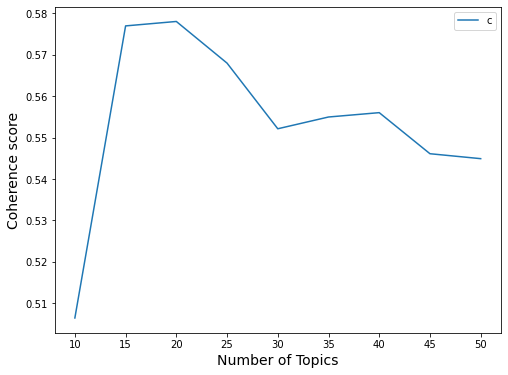

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

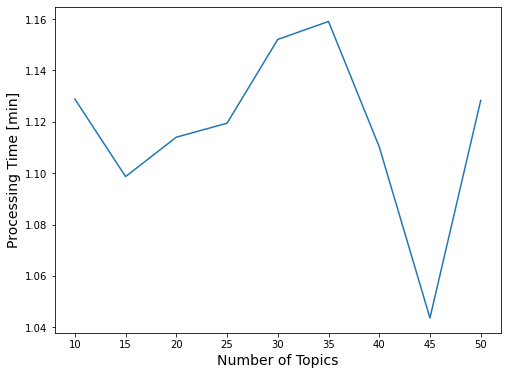

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.506480353160797,
 0.576949374828253,
 0.5780195798599205,
 0.5679685716806258,
 0.5521311607191435,
 0.5549690281528094,
 0.5560191538560065,
 0.5461099302133453,
 0.5449182282325434]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[1.1288675626118978,
 1.098670486609141,
 1.1140063325564067,
 1.1194557825724283,
 1.1520786166191102,
 1.1590766032536826,
 1.110263725121816,
 1.0435985445976257,
 1.1283179640769958]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[10, 15, 20, 25, 30, 35, 40, 45, 50]

In [9]:
## 2. Run
# Apply the defined function relying on LdaMulticore models on another grid for values for the number of topics K
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, it_tx, min_k = 1, max_k = 5, step = 4)

Processing time to build the LDA multicore model with 1 topics: 0.23259060780207316 minutes
Coherence Score of the LDA multicore model with 1 topics: 0.22693831248814833
Processing time to build the LDA multicore model with 5 topics: 1.0944539546966552 minutes
Coherence Score of the LDA multicore model with 5 topics: 0.5284691645013406


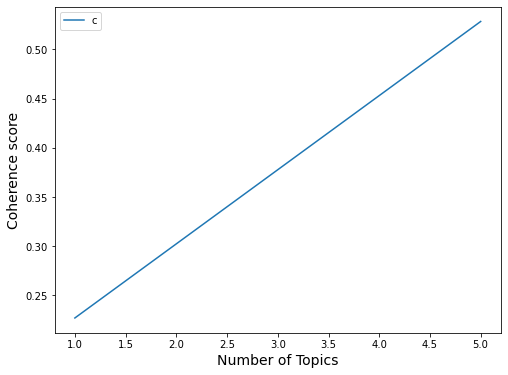

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

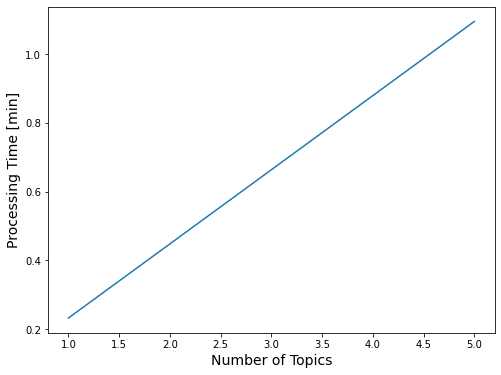

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.22693831248814833, 0.5284691645013406]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[0.23259060780207316, 1.0944539546966552]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[1, 5]

In [9]:
## 3. Run
# Apply the defined function relying on LdaMulticore models on another grid for values for the number of topics K
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, it_tx, min_k = 11, max_k = 14, step = 1)

Processing time to build the LDA multicore model with 11 topics: 1.1099273681640625 minutes
Coherence Score of the LDA multicore model with 11 topics: 0.5411155594140823
Processing time to build the LDA multicore model with 12 topics: 1.078340220451355 minutes
Coherence Score of the LDA multicore model with 12 topics: 0.5548665107068176
Processing time to build the LDA multicore model with 13 topics: 1.0790219068527223 minutes
Coherence Score of the LDA multicore model with 13 topics: 0.5591662196595676
Processing time to build the LDA multicore model with 14 topics: 1.083787695566813 minutes
Coherence Score of the LDA multicore model with 14 topics: 0.558574929306796


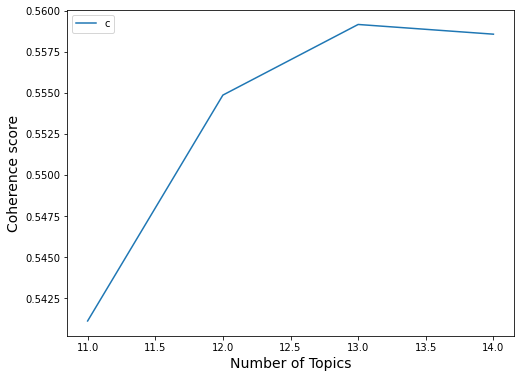

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

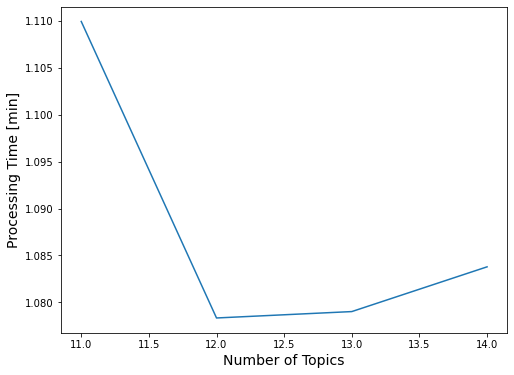

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.5411155594140823, 0.5548665107068176, 0.5591662196595676, 0.558574929306796]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[1.1099273681640625, 1.078340220451355, 1.0790219068527223, 1.083787695566813]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[11, 12, 13, 14]

In [9]:
## 4. Run
# Apply the defined function relying on LdaMulticore models on another grid for values for the number of topics K
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, it_tx, min_k = 16, max_k = 19, step = 1)

Processing time to build the LDA multicore model with 16 topics: 0.9901955326398214 minutes
Coherence Score of the LDA multicore model with 16 topics: 0.5805132707974178
Processing time to build the LDA multicore model with 17 topics: 0.9973936915397644 minutes
Coherence Score of the LDA multicore model with 17 topics: 0.5640134238851149
Processing time to build the LDA multicore model with 18 topics: 1.0215100685755412 minutes
Coherence Score of the LDA multicore model with 18 topics: 0.5768914492223396
Processing time to build the LDA multicore model with 19 topics: 1.027110012372335 minutes
Coherence Score of the LDA multicore model with 19 topics: 0.5643455656475502


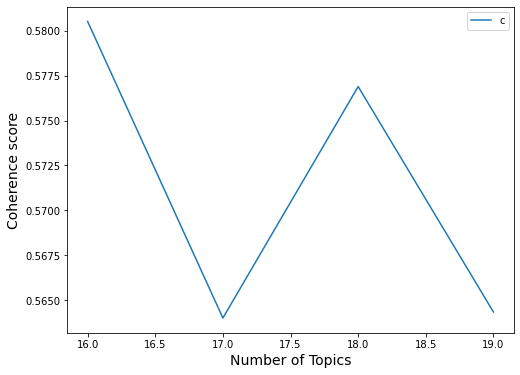

In [10]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

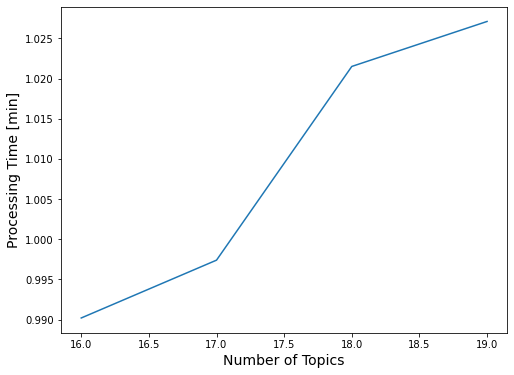

In [11]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [12]:
# Take a look at the resulting coherence scores
coherence_values

[0.5805132707974178,
 0.5640134238851149,
 0.5768914492223396,
 0.5643455656475502]

In [13]:
# Take a look at the required processing times (in minutes)
processing_times

[0.9901955326398214, 0.9973936915397644, 1.0215100685755412, 1.027110012372335]

In [14]:
# Take a look at the grid of the number of topics
n_topics

[16, 17, 18, 19]

In [21]:
## 5. Run
# Apply the defined function relying on LdaMulticore models on another grid for values for the number of topics K
coherence_values, processing_times, n_topics = compare_lda_models(dictionary, corpus, it_tx, min_k = 21, max_k = 24, step = 1)

Processing time to build the LDA multicore model with 21 topics: 1.1735108852386475 minutes
Coherence Score of the LDA multicore model with 21 topics: 0.5701450392357017
Processing time to build the LDA multicore model with 22 topics: 1.1151102383931477 minutes
Coherence Score of the LDA multicore model with 22 topics: 0.5693639907821711
Processing time to build the LDA multicore model with 23 topics: 1.0811994870503743 minutes
Coherence Score of the LDA multicore model with 23 topics: 0.5613389498120472
Processing time to build the LDA multicore model with 24 topics: 1.1311161359151205 minutes
Coherence Score of the LDA multicore model with 24 topics: 0.5724352408109232


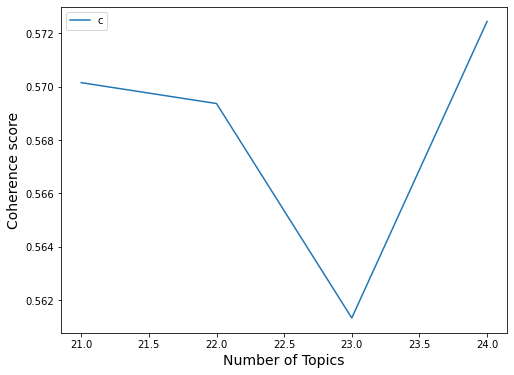

In [22]:
# Show the learning curve of the LdaMulticore model
plt.plot(n_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

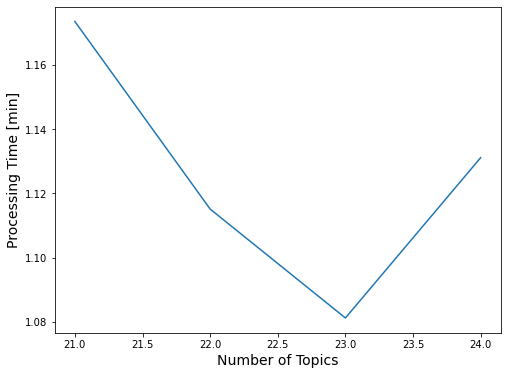

In [23]:
# Show the evolvement of the processing time 
plt.plot(n_topics, processing_times)
plt.xlabel("Number of Topics")
plt.ylabel("Processing Time [min]")
plt.show()

In [24]:
# Take a look at the resulting coherence scores
coherence_values

[0.5701450392357017,
 0.5693639907821711,
 0.5613389498120472,
 0.5724352408109232]

In [25]:
# Take a look at the required processing times (in minutes)
processing_times

[1.1735108852386475,
 1.1151102383931477,
 1.0811994870503743,
 1.1311161359151205]

In [26]:
# Take a look at the grid of the number of topics
n_topics

[21, 22, 23, 24]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.2 Summarize and Visualize the Results </h2>
</div>

In [5]:
## Storage of the results for LdaMulticore model with passes = 12
# 1. Run
coherence_values = [0.506480353160797, 0.576949374828253, 0.5780195798599205, 0.5679685716806258, 0.5521311607191435, 0.5549690281528094, 0.5560191538560065, 0.5461099302133453, 0.5449182282325434]
processing_times = [1.1288675626118978, 1.098670486609141, 1.1140063325564067, 1.1194557825724283, 1.1520786166191102, 1.1590766032536826, 1.110263725121816, 1.0435985445976257, 1.1283179640769958]
n_topics = [10, 15, 20, 25, 30, 35, 40, 45, 50]

# 2. Run
coherence_values = [0.22693831248814833, 0.5284691645013406]
processing_times = [0.23259060780207316, 1.0944539546966552]
n_topics = [1, 5]

# 3. Run
coherence_values = [0.5411155594140823, 0.5548665107068176, 0.5591662196595676, 0.558574929306796]
processing_times = [1.1099273681640625, 1.078340220451355, 1.0790219068527223, 1.083787695566813]
n_topics = [11, 12, 13, 14]

# 4. Run
coherence_values = [0.5805132707974178, 0.5640134238851149, 0.5768914492223396, 0.5643455656475502]
processing_times = [0.9901955326398214, 0.9973936915397644, 1.0215100685755412, 1.027110012372335]
n_topics = [16, 17, 18, 19]

# 5. Run
coherence_values = [0.5701450392357017, 0.5693639907821711, 0.5613389498120472, 0.5724352408109232]
processing_times = [1.1735108852386475, 1.1151102383931477, 1.0811994870503743, 1.1311161359151205]
n_topics = [21, 22, 23, 24]


# Joint
coherence_values = [0.22693831248814833, 0.5284691645013406, 0.506480353160797,  0.5411155594140823, 0.5548665107068176, 
                    0.5591662196595676,  0.558574929306796,  0.576949374828253,  0.5805132707974178, 0.5640134238851149, 
                    0.5768914492223396,  0.5643455656475502, 0.5780195798599205, 0.5701450392357017, 0.5693639907821711, 
                    0.5613389498120472,  0.5724352408109232, 0.5679685716806258, 0.5521311607191435, 0.5549690281528094, 
                    0.5560191538560065,  0.5461099302133453, 0.5449182282325434]

processing_times = [0.23259060780207316, 1.0944539546966552, 1.1288675626118978, 1.1099273681640625, 1.078340220451355, 
                    1.0790219068527223,  1.083787695566813,  1.098670486609141,  0.9901955326398214, 0.9973936915397644, 
                    1.0215100685755412,  1.027110012372335,  1.1140063325564067, 1.1735108852386475, 1.1151102383931477, 
                    1.0811994870503743,  1.1311161359151205, 1.1194557825724283, 1.1520786166191102, 1.1590766032536826, 
                    1.110263725121816,   1.0435985445976257, 1.1283179640769958]
n_topics = [1,  5,  10, 11, 12, 
            13, 14, 15, 16, 17, 
            18, 19, 20, 21, 22, 
            23, 24, 25, 30, 35, 
            40, 45, 50]

In [6]:
## Fit a logarithmic model to the resulting coherence scores to get a smooth approximation of the learning curve
# Generate the required logarithmic features on the basis of the n_topics variable
X = np.column_stack((n_topics, np.log(n_topics)))
# Set up and fit the logarithmic regression model
reg = linear_model.LinearRegression(fit_intercept = True)
reg.fit(X, coherence_values)
# Get the fitted values for a homogenous grid of 300 values between the maximum and the minimum n_topics
xnew = np.linspace(np.min(n_topics), np.max(n_topics), 300)
coherence_values_smoothed = reg.predict(np.column_stack((xnew, np.log(xnew))))

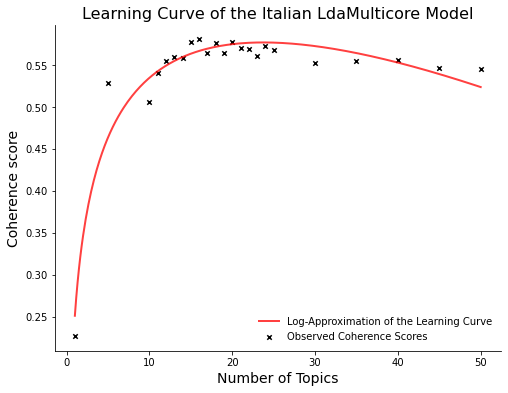

In [7]:
# Show the actual coherence scores obtained together with the smoothly approximated learning curve of the LdaMulticore model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(n_topics, coherence_values, color = 'black', s = 20, marker = 'x', label = 'Observed Coherence Scores')
#ax.plot(n_topics, coherence_values, color = 'black', linewidth = 1.5, alpha = 0.7, linestyle = '--', label = 'True Learning Curve')
ax.plot(xnew, coherence_values_smoothed, color = 'red', linewidth = 2, alpha = 0.75, label = 'Log-Approximation of the Learning Curve')
ax.set(title = "Learning Curve of the Italian LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Coherence score")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

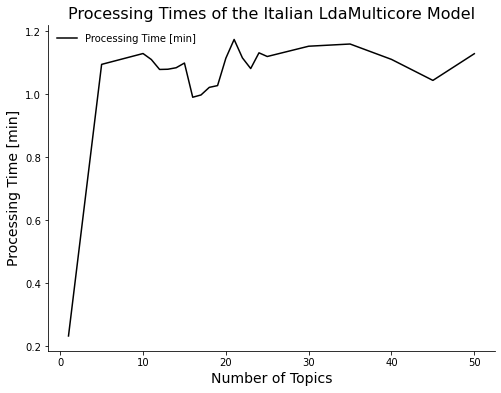

In [8]:
# Show the evolvement of the processing time
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, processing_times, color = 'black', linewidth = 1.5, alpha = 1, linestyle = '-', label = 'Processing Time [min]')
ax.set(title = "Processing Times of the Italian LdaMulticore Model",
       xlabel = "Number of Topics",
       ylabel = "Processing Time [min]")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7.3 Determine the optimal K </h2>
</div>

To get a starting point for finding the optimal number of topics $K^*$, we focus on two measures of the estimated models: (1) the coherence score $c(K)$ and (2) the maximal Jaccardian similarity $j(K)$ observed between the top 10 keywords of two of the resulting topics, which is defined by

$$
j(K) = max \left(\frac{|(S_i \cap S_j)|}{|(S_i \cup S_j)|}\right), \ \text{for} \ i \neq j \ \text{and} \ i,j \in \{1,\dots,K\}
$$

where $K$ corresponds to the number of topics in the model and $S_i$ is the set consisting of the top 10 keywords of the $i^{th}$ topic from the model under consideration (note: the maximal Jaccardian similarity measures the highest similarity between two of the resulting topics of a topic model). Our aim is to choose $K$ such that for the corresponding model $c(K)$ is maximized and $j(K)$ is minimized. Since both of these metrics are measured on a scale between 0 and 1, they are directly comparable to each other such that the weighted quality of a model $q_\lambda(K)$ can be measured by the following formula: 

$$
q_\lambda(K) = 2*(\lambda*c(K) - (1-\lambda)*j(K)),
$$

where $\lambda \in [0,1]$ corresponds to the weight assigned to $c(K)$, such that th weight assigned to $j(K)$ is given by $(1-\lambda)$. However, in the present study, we opt for equal weighting of both metrics (i.e. $\lambda = \frac{1}{2}$) to obtain an initial estimate for $K^*$. The topic model relying on the such revealed "optimal" number of topics, $K^*$, is then taken as the first model for the manual review. Then, if the initially selected model appears to deliver too coarse (or too granular) topics, we increase (or decreases) $K$ until a reasonable partitioning is achieved. Furthermore, topic models for which one can reasonably argue that the number of topics is probably too small (e.g. in the context of newspaper articles this would be the case if $K$ is smaller than the number of topics by which most established news outlets sort their articles) are not considered while choosing the opitmal $K$ by means of the approach described above.

In [5]:
# Retrieve the results of the potentially optimal topic models
coherence_values = [0.506480353160797,  0.5411155594140823, 0.5548665107068176, 
                    0.5591662196595676, 0.558574929306796,  0.576949374828253,  0.5805132707974178, 0.5640134238851149, 
                    0.5768914492223396, 0.5643455656475502, 0.5780195798599205, 0.5701450392357017, 0.5693639907821711, 
                    0.5613389498120472, 0.5724352408109232, 0.5679685716806258, 0.5521311607191435, 0.5549690281528094, 
                    0.5560191538560065, 0.5461099302133453, 0.5449182282325434]

processing_times = [1.1288675626118978, 1.1099273681640625, 1.078340220451355, 
                    1.0790219068527223, 1.083787695566813,  1.098670486609141,  0.9901955326398214, 0.9973936915397644, 
                    1.0215100685755412, 1.027110012372335,  1.1140063325564067, 1.1735108852386475, 1.1151102383931477, 
                    1.0811994870503743, 1.1311161359151205, 1.1194557825724283, 1.1520786166191102, 1.1590766032536826, 
                    1.110263725121816,  1.0435985445976257, 1.1283179640769958]
n_topics = [10, 11, 12, 
            13, 14, 15, 16, 17, 
            18, 19, 20, 21, 22, 
            23, 24, 25, 30, 35, 
            40, 45, 50]

In [6]:
# Define the number of top keywords to use while calculating the Jaccardian similarities between topics
num_keywords = 10

# Create a dictionary to store the LDA models
LDA_models = {}

# Create a dictionary to store the top keywords for each topic of the LDA models
LDA_topics = {}

In [7]:
# Load all desired models and extract the corresponding top keywords for their topics
for i in n_topics:
    # Load the model and store it into the LDA_models dictionary
    LDA_models[i] = gensim.models.ldamodel.LdaModel.load("LDA/it_lda_model_"+str(i)+"_topics")
    # Extract the num_keywords top keywords for each topic from the model with i topics and store them accordingly in the LDA_topics dictionary
    shown_topics = LDA_models[i].show_topics(num_topics = i, 
                                              num_words = num_keywords,
                                              formatted = False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [8]:
# Create a function to calculate the Jaccard similarity of two topics
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = |(A ∩ B)| / |(A ∪ B)|
    - For LDA, the Goal is a low maximal Jaccard score between the topics of a model
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [9]:
## Apply the above defined function to derive the maximal Jaccardian similarity between the top words of the resulting topics for each model
# Create storage to save the maximal topic similarity for each model
max_topic_similarities = []
# Set up a loop to iterate through all models
for model in n_topics:
    # Create storage to save the topic similarities of all possible topic pairs
    topic_similarities = []
    # Get the topics of the current model
    topics = LDA_topics[model]
    # Set up a loop to calculate the topic similarity for all possible topic pairs
    for i in range(model):
        # Set the maximal topic similarity to 0 for the baseline model, which contains only 1 topic
        if model == 1:
            topic_similarities.append(0)
        # Calculate the topic similarity for all possible topic pairs otherwise
        elif i+1 < model:
            for j in range(i+1,model):
                topic_similarities.append(jaccard_similarity(topics[i], topics[j]))
    # Get the maximal topic similarity of the model and store it within the max_topic_similarities variable
    max_topic_similarities.append(np.max(topic_similarities))

# Take a look at the result
#max_topic_similarities

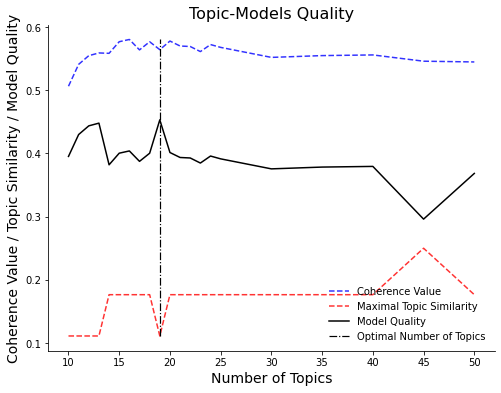

In [14]:
# Calculate the qualities of the models
qualities = np.array(coherence_values) - np.array(max_topic_similarities)

# Calculate the optimal number of topics
opt_n_topic = n_topics[np.argmax(np.array(qualities))]

# Show the development of the coherence scores, the maximal Jaccardian similarities and the model qualities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_topics, coherence_values, color = 'blue', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Coherence Score')
ax.plot(n_topics, max_topic_similarities, color = 'red', linewidth = 1.5, alpha = 0.8, linestyle = '--', label = 'Maximum Topic Similarity')
ax.plot(n_topics, qualities, color = 'black', linewidth = 1.5, alpha = 1, label = 'Model Quality')
ax.plot(np.repeat(opt_n_topic,2), [np.min(max_topic_similarities), np.max(coherence_values)], 
        color = 'black', linewidth = 1.2, alpha = 1, linestyle = '-.', label = 'Optimal Number of Topics')
ax.set(title = "Topic-Models Quality",
       xlabel = "Number of Topics",
       ylabel = "Coherence Score / Topic Similarity / Model Quality")
ax.legend(loc = 'best', frameon = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [15]:
# Display the optimal number of topics
print('The optimal number of topics is', opt_n_topic)

The optimal number of topics is 19


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 8. Inspect the optimal LDA topic model </h2>
</div>

Since manual inspection of the topic model with 19 topics reveals that this model still yields rather coarse topics, we decide to increase $K$ until the corresponding model exhibits reasonably partitioned topics. For the Italian articles, this strategy leads us to an optimal choice of $K^* = 20$ for the general LDA model.

In [5]:
# Load the optimal model from disk and print the topics (adjust the digit appropriately!!!)
opt_n_topic = 20  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/it_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 10, formatted = False)
pprint(optimal_model.print_topics(num_topics = opt_n_topic, num_words = 10))

[(0,
  '0.051*"politico" + 0.042*"attualità" + 0.027*"presidente" + 0.019*"trump" + '
  '0.018*"uniti" + 0.018*"keystone" + 0.014*"americano" + 0.012*"new" + '
  '0.012*"york" + 0.011*"dichiarare"'),
 (1,
  '0.023*"keystone" + 0.014*"gara" + 0.014*"finale" + 0.013*"aereo" + '
  '0.013*"succedere" + 0.012*"quarto" + 0.012*"terzo" + 0.012*"vincere" + '
  '0.011*"classificare" + 0.011*"campione"'),
 (2,
  '0.028*"lugano" + 0.022*"evento" + 0.020*"locarno" + 0.019*"festival" + '
  '0.018*"sabato" + 0.017*"edizione" + 0.011*"programmare" + 0.011*"teatro" + '
  '0.010*"domenica" + 0.010*"spettacolo"'),
 (3,
  '0.025*"natale" + 0.024*"treno" + 0.020*"franco" + 0.019*"trasportare" + '
  '0.015*"stazione" + 0.014*"offrire" + 0.013*"svizzera" + 0.013*"viaggiare" + '
  '0.012*"ffs" + 0.011*"dicembre"'),
 (4,
  '0.051*"coop" + 0.027*"cliente" + 0.024*"produrre" + 0.022*"vendita" + '
  '0.017*"prezzo" + 0.016*"online" + 0.015*"ch" + 0.012*"negoziare" + '
  '0.012*"acquistare" + 0.012*"www"'),
 (5,


In [6]:
# Read in the preprocessed data
it_tx = read_preprocessed('it')[0]

In [7]:
# Create the corpus again
corpus = [optimal_model.id2word.doc2bow(article) for article in it_tx]

In [8]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, optimal_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.107082 -0.092749       1        1  10.501594
12    -0.002069  0.002747       2        1   9.847284
6      0.031346 -0.146511       3        1   7.756493
18     0.037734  0.147009       4        1   6.925199
7      0.126667 -0.125580       5        1   6.215365
19     0.100817 -0.043371       6        1   5.552396
5      0.115253 -0.104048       7        1   5.477145
13     0.012011  0.134529       8        1   5.044577
10     0.042031 -0.019099       9        1   4.956899
14    -0.276623 -0.019124      10        1   4.445035
17     0.118763 -0.006362      11        1   4.364928
16    -0.132584 -0.044428      12        1   4.251554
15    -0.083155  0.007139      13        1   3.838767
2      0.024852  0.145784      14        1   3.715248
9      0.064690  0.026312      15        1   3.629884
0      0.128160  0.054625      16        1   3.433662
1      0.025837  0.230746      17        1   2.929485
4     -0.069990 -0.079941      18        1   2.528482
11    -0.368217 -0.017917      19        1   2.295885
3     -0.002604 -0.049759      20        1   2.290117, topic_info=           Term         Freq         Total Category  logprob  loglift
741    politico  5870.000000   5870.000000  Default  30.0000  30.0000
70         coop  4096.000000   4096.000000  Default  29.0000  29.0000
281          fr  3515.000000   3515.000000  Default  28.0000  28.0000
390      lugano  7999.000000   7999.000000  Default  27.0000  27.0000
572           g  2473.000000   2473.000000  Default  26.0000  26.0000
..          ...          ...           ...      ...      ...      ...
258  pubblicare   328.723086   3273.472929  Topic20  -4.5607   1.4782
634    svizzera   417.772272  12532.723948  Topic20  -4.3209   0.3754
223          ch   218.455934   3515.296566  Topic20  -4.9693   0.9983
564      zurigo   194.041316   2892.719887  Topic20  -5.0878   1.0747
307   settimana   193.017189   3934.121913  Topic20  -5.0931   0.7619

[933 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
91        1  0.096874  abitare
91        2  0.015137  abitare
91        3  0.022200  abitare
91        5  0.021191  abitare
91        6  0.083755  abitare
...     ...       ...      ...
203      16  0.020641        è
203      17  0.004634        è
203      18  0.017131        è
203      19  0.003370        è
203      20  0.011093        è

[9521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 13, 7, 19, 8, 20, 6, 14, 11, 15, 18, 17, 16, 3, 10, 1, 2, 5, 12, 4])

In [9]:
# Delete unnecessary variables
del it_tx

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Find the most likely topic for each document </h2>
</div>

In [10]:
# Read in the preprocessed fulltext data
it_tx_fulltext, it_idx = read_preprocessed_fulltext('it')

In [11]:
# Define a function to retrieve the topic id of the most likely topic assignment for each article together with the according topic affiliation probability
def get_article_topics(ldamodel, corpus, second_most = False):
    # Create storage to save the id of the assigned topics and the according topic affiliation probabilities
    assigned_topics = []
    affiliation_probs = []
    # Keep track of the processing time
    t = time.time()
    # Get the most dominant topic for each document
    for topic_dist_tuples in ldamodel.get_document_topics(corpus):
        # Get a tuple containing the topic id of the second most dominant topic together with the according topic affiliation probability if second_most = True
        if second_most:
            try:
                topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[1]
            # If the affiliation probability of the second topic is below 0.01, then the topic is ignored and we therefore return a tuple of NAs
            except:
                topic_prob_tuple = (np.nan, np.nan)
        # Get a tuple containing the topic id of the most dominant topic together with the according topic affiliation probability otherwise
        else:
            topic_prob_tuple = sorted(topic_dist_tuples, key = lambda tup: tup[1], reverse = True)[0]
        # Extract the topic id of the most dominant topic
        assigned_topics.append(topic_prob_tuple[0])
        # Extract the according topic affiliation probability
        affiliation_probs.append(topic_prob_tuple[1])
    # Print out the processing time
    if second_most:
        print("Processing time to retrieve the second most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    else:
        print("Processing time to retrieve the most dominant topic for each article:", str((time.time() - t)/60), "minutes")
    
    # Return the results
    return assigned_topics, affiliation_probs

In [12]:
# Apply the above defined function to get the most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_1, affiliation_prob_1 = get_article_topics(optimal_model, corpus, second_most = False)

Processing time to retrieve the most dominant topic for each article: 0.17959365049997966 minutes


In [13]:
# Apply the above defined function to get the second most likely topic assignments together with the according topic affiliation probabilities
assigned_topic_2, affiliation_prob_2 = get_article_topics(optimal_model, corpus, second_most = True)

Processing time to retrieve the second most dominant topic for each article: 0.1799953818321228 minutes


In [14]:
# Create a correctly indexed dataframe containing the topic assignment and the according topic affiliation probability
topic_df = pd.DataFrame(assigned_topic_1, index = it_idx.it_idx.values.tolist(), columns = ['Topic_ID_1'])
topic_df['Affiliation_Prob_1'] = affiliation_prob_1
topic_df['Topic_ID_2'] = assigned_topic_2
topic_df['Affiliation_Prob_2'] = affiliation_prob_2
# Save the results to a csv file
topic_df.to_csv("LDA/Topic_Assignment/it_topic_assignment.csv", index = True)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10. Get the most representative articles for each topic (preparation) </h2>
</div>

In [5]:
# Load the optimal model from disk and save the topics' keywords
opt_n_topic = 20  # adjust the digit accordingly to load the desired model
optimal_model = gensim.models.ldamodel.LdaModel.load("LDA/it_lda_model_"+str(opt_n_topic)+"_topics")         
model_topics = optimal_model.show_topics(num_topics = opt_n_topic, num_words = 20, formatted = False)

In [6]:
# Read in the Dataframe containing the topic assignments
topic_df = pd.read_csv("LDA/Topic_Assignment/it_topic_assignment.csv", index_col = 0, dtype = {'Topic_ID_1': int, 'Affiliation_Prob_1': float, 'Topic_ID_2': float, 'Affiliation_Prob_2': float})

In [7]:
# Read in the preprocessed fulltext data
it_tx_fulltext, it_idx = read_preprocessed_fulltext('it')

In [8]:
# Define a function to display the most representative articles for each topic
def get_representative_articles(fulltext_data, index_df, topic_assignment_df, topic_id, n_top_articles = 5, show_n_last_elements = None):
    # Define the variable show_n_last_elements appropriatly if it is not defined
    if show_n_last_elements == None:
        show_n_last_elements = n_top_articles
    # Get the index of the most representative articles for the focal topic
    article_ids = topic_assignment_df.loc[topic_assignment_df['Topic_ID_1'] == topic_id].sort_values(by = ['Affiliation_Prob_1'], ascending = False)[:n_top_articles].index
    # Get the location of theses articles in the list of fulltexts
    location = []
    for article_id in article_ids:
        location.append(index_df.loc[index_df.iloc[:,0] == article_id].index[0])
    # Print out the identified articles
    return list(fulltext_data[i] for i in location)[(n_top_articles-show_n_last_elements):]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10.1 Display most representative articles for each topic </h2>
</div>

In [9]:
## Topic 0
# Define the id of the topic of interest
id_focal_topic = 0
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(0,
 [('politico', 0.051165678),
  ('attualità', 0.041574948),
  ('presidente', 0.026923014),
  ('trump', 0.019091949),
  ('uniti', 0.018446049),
  ('keystone', 0.017808408),
  ('americano', 0.014101109),
  ('new', 0.011589262),
  ('york', 0.011547314),
  ('dichiarare', 0.01140768),
  ('donald', 0.008917888),
  ('washington', 0.008567417),
  ('cina', 0.007570979),
  ('usa', 0.0071881195),
  ('dollaro', 0.0067103854),
  ('unito', 0.0065996563),
  ('londra', 0.006175048),
  ('regno', 0.0061435476),
  ('britannico', 0.005883148),
  ('premier', 0.005652712)])


[' Attualità, politica, economiaCARACAS. L’uso della forza in Venezuela è un’opzione. Lo ha dichiarato il presidente degli Stati Uniti Donald Trump nel corso di un’intervista alla Cbs. Non voglio dirlo. Ma sicuramente è qualcosa ha affermato Trump, che rivela di aver rifiutato di vedere il suo omologo Nicolas Maduro negli scorsi mesi. Ha chiesto un incontro e l’ho respinto, motivando il diniego con le cose terribili che stanno accadendo nel paese. Maduro ha replicato così: Nessuno può rispondere con certezza se si arriverà alla guerra civile. Dipende dal livello di pazzia dell’impero settentrionale (gli Usa, ndr) e dei suoi alleati. La gente si sta già armando. Sabato è stata la giornata di due grandi manifestazioni di segno opposto: da una parte chi vuole un nuovo governo e dall’altra i sostenitori di Maduro. Ieri sera è inoltre scaduto l’ultimatum lanciato da Francia, Germania, Spagna, Portogallo, Olanda e Regno Unito per l’indizione di nuove elezioni presidenziali. FC',
 ' Attualità

In [10]:
## Topic 1
# Define the id of the topic of interest
id_focal_topic = 1
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(1,
 [('keystone', 0.023471657),
  ('gara', 0.0142414225),
  ('finale', 0.013677958),
  ('aereo', 0.013291856),
  ('succedere', 0.012565163),
  ('quarto', 0.012304803),
  ('terzo', 0.012134095),
  ('vincere', 0.011977208),
  ('classificare', 0.010992543),
  ('campione', 0.01052873),
  ('volare', 0.009498617),
  ('campire', 0.009448433),
  ('pilotare', 0.009422578),
  ('punto', 0.009377862),
  ('elvetico', 0.008959014),
  ('vittoria', 0.007943162),
  ('secondo', 0.0077654584),
  ('turno', 0.0074996753),
  ('ultimo', 0.00724735),
  ('carriera', 0.00693619)])


[' ST. MORITZ/VAL D’ISÈRE. Per i colori rossocrociati, quello appena andato agli archivi, è stato un fine settimana in chiaroscuro. Sulle nevi di casa di St. Moritz Lara Gut Behrami ha disputato un buon super G, chiudendo al quinto posto e lasciandosi alle spalle il weekend nero di Lake Louise. La speranza è che questo piazzamento possa essere un punto di partenza per una stagione seppur ancora molto giovane sin qui al di sotto delle aspettative. A dominare sulle nevi engadinesi sono state le sciatrici italiane, con Sofia Goggia a staccare il primo posto davanti (di un piccolissimo centesimo!) alla connazionale Federica Brignone. Terza la leader della generale Mikaela Shiffrin. Ieri, invece, si è disputato il parallelo. Il successo è andato a Petra Vlhova che, in finale, ha battuto la svedese Anna Swenn Larsson. La slovacca si è aggiudicata i 100 punti in palio grazie a un guizzo nelle ultime porte, che le ha permesso di superare la rivale di 0”02. Terzo posto per l’austriaca Franziska

In [11]:
## Topic 2
# Define the id of the topic of interest
id_focal_topic = 2
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(2,
 [('lugano', 0.027960492),
  ('evento', 0.021733694),
  ('locarno', 0.019976344),
  ('festival', 0.019265814),
  ('sabato', 0.0182801),
  ('edizione', 0.016778573),
  ('programmare', 0.010794704),
  ('teatro', 0.010573241),
  ('domenica', 0.010223398),
  ('spettacolo', 0.010076828),
  ('appuntamento', 0.01002531),
  ('musico', 0.0098925885),
  ('ch', 0.009767932),
  ('venerdì', 0.009749775),
  ('serata', 0.009348782),
  ('piazza', 0.009052778),
  ('pubblicare', 0.00855348),
  ('bellinzona', 0.0083609065),
  ('festa', 0.008120623),
  ('manifestazione', 0.0078813145)])


[' CHIASSO. Al Murrayfield Pub di Chiasso questa sera arriva la “Broken City Night”, un evento dove la buona musica e la birra saranno i protagonisti. Le sonorità della serata saranno affidate a Radio Gwendalyn, che per l’occasione sfodererà il poliedrico Fratello del Sole Jr. A partire dalle 20, party fino alle 2 del mattino. 13. 09. 19BAR VIALEBELLINZONA. Si prosegue con gli appuntamenti del weekend al Bar Viale di Bellinzona, “Music 4 the weekend”. Questa sera in consolle si esibirà Chris Leòn, mentre ad animare il sabato sera ci penserà il duo Tindaro&JimCash. Al Bar Viale il weekend prende ufficialmente avvio questa sera alle 22 con i dj set. 13 14. 09. 19LABIRINT CLUBCASTIONE. È tutto pronto per l’apertura ufficiale del nuovo Labirint Club, che promette di essere un locale notturno diverso dal solito. Le due sale rinnovate ospiteranno Dj Panico, Ricky Pellegrino, Dj Marcy, Frank Storm, Ivan Alvarez e Kenny Ground. Sulle ceneri della Fabrique, si riparte sabato sera a partire dall

In [12]:
## Topic 3
# Define the id of the topic of interest
id_focal_topic = 3
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(3,
 [('natale', 0.02508617),
  ('treno', 0.024214052),
  ('franco', 0.020420523),
  ('trasportare', 0.018996425),
  ('stazione', 0.01452989),
  ('offrire', 0.013924862),
  ('svizzera', 0.013287511),
  ('viaggiare', 0.012559087),
  ('ffs', 0.011898761),
  ('dicembre', 0.011467904),
  ('biglietto', 0.011205688),
  ('pubblicare', 0.010455245),
  ('sciare', 0.00999574),
  ('prezzo', 0.009860541),
  ('orario', 0.009609975),
  ('neve', 0.008666449),
  ('hotel', 0.008663865),
  ('zona', 0.008064883),
  ('mezzo', 0.007920025),
  ('trasporto', 0.007806937)])


[' AutoPostale e il potenziamento del trasporto pubblico in Ticino. In occasione del cambio d’orario del 13 dicembre 2020, in concomitanza con l’apertura della galleria di base del Monte Ceneri, il trasporto pubblico in Ticino sarà potenziato. Dal 13 dicembre AutoPostale circolerà in maniera più frequente e capillare in tutto il Cantone. Il 5 aprile 2021 farà seguito un secondo cambio d’orario, quando la nuova galleria di base del Monte Ceneri sarà totalmente operativa, per permettere di adattare le coincidenze del trasporto su gomma ai nuovi orari dei treni. I cambiamenti di dicembre si traducono in: Aumento della frequenza. L’aumento della frequenza va a toccare le linee regionali principali con corse tutti i giorni ogni 30 minuti tra le 6 e le 20, e servizio serale assicurato fino alle 24. Le linee secondarie invece vedranno un potenziamento a seconda delle necessità. In generale si può dire che sarà possibile, da ogni località, raggiungere il polo di riferimento entro le 6 del matt

In [13]:
## Topic 4
# Define the id of the topic of interest
id_focal_topic = 4
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(4,
 [('coop', 0.05147747),
  ('cliente', 0.027176218),
  ('produrre', 0.024160529),
  ('vendita', 0.022499718),
  ('prezzo', 0.017269136),
  ('online', 0.015758015),
  ('ch', 0.015113535),
  ('negoziare', 0.01188061),
  ('acquistare', 0.011797996),
  ('www', 0.011793319),
  ('servizio', 0.01122853),
  ('offrire', 0.01052219),
  ('negozio', 0.008587462),
  ('app', 0.008443154),
  ('buono', 0.007700085),
  ('foto', 0.007401879),
  ('piccolo', 0.007347136),
  ('sito', 0.0070862165),
  ('carta', 0.0070480076),
  ('nuovo', 0.006897103)])


[' Perché Coop cambia operatore da Salt a Swisscom? Quali conseguenze per i clienti di Coop Mobile?Per i clienti telefonare e navigare sarà più conveniente. Con il cambio beneficiano dei vantaggi del leader del mercato svizzero. Per esempio, la migliore rete di telefonia mobile del Paese (vincitore del test nel magazine Chip 5/2018). Cosa devono fare i clienti?Chi vuole restare da Coop Mobile deve stipulare un nuovo contratto prepaid. Chi vuole telefonare con un abbonamento deve ugualmente fare un nuovo abbonamento Coop Mobile. Se uno non fa niente, rimane come ora cliente di Salt, il nome Coop Mobile non esiste più e non si può più pagare con i Superpunti. Si possono usare i Superpunti con il nuovo Coop Mobile?Chi ha un nuovo contratto prepaid o un abbonamento può usare i suoi Superpunti per pagare la carta SIM e il credito di chiamate (prepaid), nonché la fattura della telefonia mobile. Perché il cambio di operatore non avviene automaticamente?Perché è necessario un contratto tra il 

In [14]:
## Topic 5
# Define the id of the topic of interest
id_focal_topic = 5
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(5,
 [('covid', 0.021976331),
  ('coronavirus', 0.019878771),
  ('caso', 0.016859781),
  ('virus', 0.013854263),
  ('paziente', 0.01327946),
  ('positivo', 0.01215933),
  ('malattia', 0.012089482),
  ('ospedale', 0.011470879),
  ('test', 0.010150385),
  ('medicare', 0.0099663),
  ('nuovo', 0.009888845),
  ('numerare', 0.009202393),
  ('pandemia', 0.009071465),
  ('sanitario', 0.009057793),
  ('rischiare', 0.009045518),
  ('mascherina', 0.0089231245),
  ('medico', 0.008867253),
  ('contagiare', 0.007942279),
  ('decesso', 0.00780259),
  ('vaccinare', 0.0074693495)])


[' BELLINZONA. Sono 182 i casi dall’inizio dell’anno. Il medico cantonale: La diagnosi precoce è importante, così come sottoporsi al trattamento. Clamidia e gonorrea sono attualmente le malattie sessualmente trasmissibili più frequenti in Ticino. Da gennaio a oggi sono 182 i casi di infezioni da clamidia, pari a uno al giorno. Sono stati 36 quelli di gonorrea. Nel 2018 se ne contano rispettivamente 465 e 83. Stabili i casi di sifilide (40 nel 2018, 23 negli ultimi sei mesi). Mentre sono “solo” tre i casi dichiarati di Hiv finora nel 2019, in costante calo dopo il record del 2016 (erano 26 tre anni fa, 17 nel 2017, 16 nel 2018). Il preservativo viene usato per evitare la gravidanza, dimenticando spesso le malattie. Così ogni giorno nel mondo più di un milione di persone tra i 15 e 49 anni rimangono contagiate da infezioni sessualmente trasmissibili curabili (dati Organizzazione mondiale della sani tà). Eppure si tratta di malattie da cui è possibile proteggersi. Come mai, allora, nonost

In [15]:
## Topic 6
# Define the id of the topic of interest
id_focal_topic = 6
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(6,
 [('svizzera', 0.021223964),
  ('azienda', 0.017411139),
  ('produrre', 0.01447277),
  ('svizzero', 0.013358778),
  ('sviluppare', 0.010410854),
  ('mercato', 0.009286985),
  ('produzione', 0.008962255),
  ('progettare', 0.00759687),
  ('ricercare', 0.007422974),
  ('settore', 0.00644622),
  ('nuovo', 0.0063025844),
  ('grande', 0.0053395117),
  ('climatico', 0.0052970825),
  ('studiare', 0.005180885),
  ('emissione', 0.005164766),
  ('livellare', 0.0051640356),
  ('energia', 0.005126708),
  ('aumentare', 0.0049634175),
  ('tecnologia', 0.0048662885),
  ('sistemare', 0.00465366)])


[' L\'anidride carbonica è il gas a effetto serra più noto. Ma non è l\'unico. A contribuire al riscaldamento globale ci sono anche il metano e il protossido di azoto. Ecco come sono evolute le loro emissioni in Svizzera e nel mondo e quali sono le soluzioni per limitarle. Il 12 dicembre 2015 è una data storica nella lotta al cambiamento climatico. Dopo intense discussioni protrattesi oltre la scadenza ufficiale della conferenza internazionale sul clima COP21, i rappresentanti di 195 Paesi hanno adottato il primo accordo globale e giuridicamente vincolante per la riduzione delle emissioni. Con l\'Accordo di Parigi sul clima, ratificato dalla Svizzera nel giugno 2017, la comunità mondiale si è impegnata a mantenere l\'aumento della temperatura del pianeta ""ben al di sotto di 2°C"" rispetto ai valori preindustriali. Ma mentre gli sforzi si concentrano sul CO2 con tasse sul carbonio e politiche volte a ridurre il ricorso alle energie fossili , altri gas si accumulano nell\'atmosfera. Gas

In [16]:
## Topic 7
# Define the id of the topic of interest
id_focal_topic = 7
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(7,
 [('situazione', 0.015165083),
  ('crisi', 0.012649663),
  ('svizzera', 0.012105882),
  ('misura', 0.0117825605),
  ('pandemia', 0.010762124),
  ('coronavirus', 0.010317613),
  ('settore', 0.00977974),
  ('economico', 0.00922161),
  ('azienda', 0.008280672),
  ('dipendere', 0.008166217),
  ('franco', 0.007951622),
  ('berna', 0.007890083),
  ('attività', 0.006938823),
  ('covid', 0.0067037935),
  ('emergenza', 0.006440785),
  ('svizzero', 0.006377504),
  ('finanziario', 0.0063665807),
  ('economia', 0.00634175),
  ('confederazione', 0.0059598824),
  ('aumentare', 0.005804258)])


[' BERNA. Lo ha deciso il Consiglio federale per far fronte all’emergenza coronavirus. La misura vale almeno fino al prossimo 19 aprile. Rallentare la diffusione del coronavirus è nell’interesse di tutti noi: un sovraccarico del sistema sanitario metterebbe a rischio tutti gli interventi urgenti. Così la presidente della Confederazione Simonetta Sommaruga, che ieri ha annunciato la situazione straordinaria per tutto il paese. Da oggi e almeno fino al prossimo 19 aprile negozi, ristoranti, bar e tutte le strutture ricreative e per il tempo libero devono restare chiusi. Fanno eccezione i negozi di generi alimentari e le strutture sanitarie. E questo vale ora per tutta la Svizzera, non solo per singoli cantoni (il Ticino aveva preso tale decisione già nel weekend). Come già avviene al confine sud, anche alle frontiere con Germania, Austria e Francia scattano i controlli e sono stati chiusi i valichi minori. Per sostenere i cantoni negli ambiti della sanità pubblica, della logistica e dell

In [17]:
## Topic 8
# Define the id of the topic of interest
id_focal_topic = 8
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 1)

(8,
 [('svizzera', 0.032632038),
  ('svizzero', 0.027237052),
  ('politico', 0.018124508),
  ('diritto', 0.014134991),
  ('votare', 0.010501865),
  ('estero', 0.009818132),
  ('iniziativa', 0.008810761),
  ('partito', 0.008055094),
  ('donna', 0.007769573),
  ('parlamentare', 0.007265405),
  ('europeo', 0.006785719),
  ('elezione', 0.006539331),
  ('swissinfo', 0.0063273087),
  ('cittadino', 0.0062586023),
  ('sistemare', 0.00613281),
  ('leggere', 0.0059293383),
  ('democrazia', 0.005823234),
  ('esternare', 0.0054280125),
  ('cantone', 0.0052426993),
  ('ch', 0.005200084)])


[' Quali partiti si sono schierati dalla parte degli svizzeri all\'estero in quest\'ultima legislatura? swissinfo. ch ha analizzato tutti gli oggetti concernenti la Quinta Svizzera trattati in Consiglio nazionale. Alexandra Kohler, Balz Rigendinger, swissinfo. chMolti dei 760\'000 cittadini svizzeri che hanno scelto di vivere all\'estero seguono con interesse la politica del loro Paese d\'origine. Vogliono che le loro preoccupazioni e i loro interessi siano presi sul serio in patria. Ma quanta attenzione vi dedicano i parlamentari delle due Camere federali? È un interrogativo a cui swissinfo. ch ha cercato di rispondere. In collaborazione con gli analisti politici dismartvote. chabbiamo esaminato attentamente la legislatura 2015 2019. Dopo aver spulciato gli oggetti deliberati negli ultimi quattro anni ne abbiamo individuati 16 trattati e votati in Consiglio nazionale attinenti a tematiche che interessano gli espatriati e sui quali l\'Organizzazione degli svizzeri all\'estero (OSE)ha e

In [18]:
## Topic 9
# Define the id of the topic of interest
id_focal_topic = 9
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(9,
 [('incidere', 0.0156197585),
  ('polizia', 0.014969237),
  ('san', 0.013022044),
  ('metro', 0.011901264),
  ('ferito', 0.011813056),
  ('strada', 0.011811107),
  ('acqua', 0.01084356),
  ('causare', 0.009006625),
  ('zona', 0.008542),
  ('intervento', 0.007986203),
  ('morto', 0.0077427067),
  ('auto', 0.0075234137),
  ('riportare', 0.0073794047),
  ('fuoco', 0.0070653013),
  ('sabato', 0.0069470294),
  ('area', 0.0068516997),
  ('notte', 0.0068244664),
  ('soccorso', 0.006764146),
  ('mattina', 0.006671809),
  ('avvenire', 0.0063936985)])


[' SAVONA. Il maltempo ha provocato danni in tutta Italia nel corso del fine settimana. Attualità, politica, economiaL’episodio più clamoroso è sicuramente quello avvenuto domenica pomeriggio alle porte di Savona: la frana di un versante montuoso che ha portato con sé una trentina di metri di un viadotto dell’autostrada A6 Torino Savona. Stando agli accertamenti dei vigili del fuoco e delle forze dell’ordine in quel momento sul ponte non stava passando nessuno e alcuni veicoli si sono fermati non molto lontano dalla voragine. È una frana profonda ha dichiarato il governatore ligure Giovanni Toti e c’è preoccupazione anche per il ponte dell’altra carreggiata, che si trova poco più a valle. Quel tratto di territorio compreso tra Piemonte e Liguria è stato particolarmente colpito da pioggia, inondazioni e smottamenti. Numerose le strade chiuse in quest’area, centinaia le persone isolate e moltissimi gli sfollati. In provincia di Alessandria una donna di 52 anni è stata travolta dalle acqu

In [19]:
## Topic 10
# Define the id of the topic of interest
id_focal_topic = 10
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(10,
 [('famiglia', 0.028402064),
  ('svizzera', 0.018165557),
  ('svizzero', 0.015853254),
  ('figlio', 0.014722109),
  ('figliare', 0.014700837),
  ('madre', 0.011443064),
  ('padre', 0.011403793),
  ('donna', 0.010130497),
  ('raccontare', 0.009702532),
  ('piccolo', 0.008985849),
  ('bambino', 0.008389189),
  ('genitore', 0.008206054),
  ('cane', 0.0077313734),
  ('animale', 0.0073496033),
  ('coppia', 0.0071828137),
  ('vivo', 0.006866976),
  ('moglie', 0.0065398565),
  ('iniziare', 0.006320501),
  ('aiutare', 0.006175094),
  ('tedesco', 0.0059584947)])


[" Tra il 1956 e il 1979 il villaggio di Dürrenäsch, nel Canton Argovia, è stato una meta turistica frequentata dagli svizzeri residenti all'estero. Molti hanno trascorso qui le vacanze nel loro paese d’origine. Provenivano dalla Francia, dalla Germania o dall'Italia. Ma anche dal Perù, dalla Colombia o da Singapore. Molti connazionali espatriati hanno trascorso le loro vacanze nella Casa per gli svizzeri all'estero a Dürrenäsch. Il villaggio argoviese era anche il luogo scelto da alcuni svizzeri all’estero che volevano tornare in Svizzera. Abbiamo trovato un video del 1963: queste immagini vi sembrano famigliari? Anche voi, oppure vostri parenti o amici, avete trascorso delle vacanze nella Casa per gli svizzeri all'estero a Dürrenasch?Swissinfo. ch è alla ricerca di testimoni che possano raccontarci le loro ferie in questo villaggio. Scriveteci:melanie. eichenberger@swissinfo. ch",
 ' Nacque a Paola nel 1416 e fu canonizzato nel 1519, 12 anni dopo la morte. L’Unicef lo proclama “Ambas

In [20]:
## Topic 11
# Define the id of the topic of interest
id_focal_topic = 11
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 2)

(11,
 [('g', 0.06720579),
  ('ca', 0.048748072),
  ('min', 0.040615853),
  ('oliare', 0.03704364),
  ('acqua', 0.033769764),
  ('forno', 0.029915983),
  ('salire', 0.026924895),
  ('pasta', 0.023097785),
  ('zuccherare', 0.02260909),
  ('burro', 0.020984994),
  ('farina', 0.019695476),
  ('carne', 0.019604476),
  ('uovo', 0.016562974),
  ('c', 0.015982168),
  ('poco', 0.015507618),
  ('minuto', 0.014407653),
  ('cottura', 0.014282237),
  ('pane', 0.013190388),
  ('succo', 0.011736246),
  ('fuoco', 0.01004919)])


['... e foderate le teglie. Tutto è pronto per inebriare la casa con il profumo di pane e biscotti! Qualche ricetta nuova per chi ama avere “le mani in pasta”. Pane alle barbabietolePer 1 pagnotta285 kcal ogni 100 gPreparazione: 20 min. Tempo totale: 3 orePer una rostiera di ca. 24 cm di Ø con coperchio (riscaldabile fino ad almeno 240 °C)Per 1 pagnotta ci vogliono350 g di farina di spelta bianca 150 g di farina integrale di PuraSpelta 1 ½ c. ni di sale 1 pacchetto di lievito secco, (ca. 7 g) 100 g di Sbrinz grattugiato 3 ½ dl di succo di barbabietola 150 g di barbabietole cotte, a dadini 100 g di gherigli di noci, tritati grossolanamente 2 c. di rosmarino, tagliato finementeEcco come FareImpasto: In un recipiente mescolare le farine, il sale, il lievito e il formaggio. Versare il succo di barbabietola, mescolare e impastare per ca. 5 min. fino a ottenere un impasto liscio e morbido. Coprire e lasciar lievitare a temperatura ambiente per ca. 1 ora e ½ finché avrà raddoppiato il volume.

In [21]:
## Topic 12
# Define the id of the topic of interest
id_focal_topic = 12
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(12,
 [('è', 0.010143671),
  ('esperienza', 0.0066395407),
  ('poco', 0.0064990576),
  ('piccolo', 0.005883849),
  ('bambino', 0.0057291733),
  ('vero', 0.0055578034),
  ('storia', 0.005492492),
  ('piacere', 0.005260992),
  ('giovane', 0.005098104),
  ('attività', 0.005042025),
  ('cosa', 0.004958896),
  ('bisognare', 0.0049532154),
  ('foto', 0.0048981584),
  ('nuovo', 0.0047834693),
  ('soprattutto', 0.004718081),
  ('realtà', 0.004714335),
  ('lingua', 0.0046796487),
  ('pensare', 0.004415165),
  ('raccontare', 0.0042079124),
  ('social', 0.004198627)])


[' LUGANO. Lo scrittore Federico Iannaccone ci racconta nel suo ultimo libro un’immersione unica e profonda nella natura incontaminata. Un’infinità di alberi, radici, suoni tanto piacevoli quanto preoccupanti, a seconda della provenienza e della distanza. È ciò che ci racconta Federico Iannaccone nel suo ultimo libro, “Il profumo della natura”. Dopo gli scorsi successi, l’autore torna così a toccarci nell’animo con storie e legami che restano impressi. Ciao Federico: un altro viaggio nella natura, come hai preso questa decisione?Un mix di amore per natura, viaggi e sport estremi mi ha portato fin da giovanissimo a sognare e progettare avventure in giro per il mondo. Ma un sogno, lasciato per troppo tempo in un cassetto, mi tormentava da diversi anni: incontrare gli orsi nel loro habitat naturale, senza protezione, senza comodità, senza aiuti. L’orso bruno: la sua fama è terribile, ma hai visto davvero tenerezza nei suoi occhi?Nella mia vita ho incontrato molti predatori considerati per

In [22]:
## Topic 13
# Define the id of the topic of interest
id_focal_topic = 13
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(13,
 [('film', 0.016634062),
  ('los', 0.011718808),
  ('angeles', 0.011604776),
  ('musico', 0.010805288),
  ('serio', 0.010737987),
  ('album', 0.010107516),
  ('brano', 0.009472887),
  ('cantare', 0.009054312),
  ('canzone', 0.008880381),
  ('pubblicare', 0.007814616),
  ('poco', 0.0077149738),
  ('storia', 0.007650646),
  ('uscire', 0.0074111535),
  ('disco', 0.007310143),
  ('è', 0.007159232),
  ('attore', 0.0070181405),
  ('singolo', 0.0069057713),
  ('fare', 0.00665575),
  ('video', 0.0056899395),
  ('scrivere', 0.005509396)])


[' LIMERICK. In pubblicazione il 26 aprile “In The End” (BMG), album che segna l’uscita definitiva dalle scene dei Cranberries. Aleggiava incredulità, in quelle ore. In quelle ore del 15 gennaio 2018, quando il mondo intero fu scosso dalla morte, avvenuta ad appena 46 anni, di Dolores O’Riordan, voce energica e anima fragile dei Cranberries. Ma nei mesi che hanno preceduto quel tragico epilogo, Dolores, in previsione della realizzazione di un nuovo disco del gruppo, aveva forgiato l’embrione di undici nuovi brani, imprimendo su nastro, per di più, la primissima versione di ognuno. Perle sonore rimaste originariamente incompiute a livello di strutture e arrangiamenti , a cui, nei mesi successivi alla sua morte, Fergal Lawler (batteria) e i fratelli Noel (chitarra con il quale Dolores era solita comporre a quattro mani, come in questo caso) e Mike (basso) Hogan hanno scelto di dare una forma definitiva, affidandole, in sede di produzione, al vecchio compagno di viaggio Stephen Street. Ne

In [23]:
## Topic 14
# Define the id of the topic of interest
id_focal_topic = 14
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(14,
 [('fr', 0.051854555),
  ('coop', 0.033979673),
  ('fruttare', 0.0140325995),
  ('bio', 0.013558945),
  ('formaggio', 0.012889808),
  ('piatto', 0.012475902),
  ('produrre', 0.011812121),
  ('foto', 0.010247784),
  ('carne', 0.010016096),
  ('grande', 0.009672357),
  ('fiore', 0.009550583),
  ('vendita', 0.009507413),
  ('cucinare', 0.0094962455),
  ('fresco', 0.009322061),
  ('latta', 0.00931153),
  ('saporire', 0.009084645),
  ('gustare', 0.007725336),
  ('verdura', 0.0077129737),
  ('www', 0.007074882),
  ('classico', 0.0069761164)])


[' Terminato il momento delle grandi abbuffate, diamo il benvenuto alle insalate. In effetti anche l’inverno ha tantoda offrire su questo fronte, con radicchio e formentino. Testo Sebastiano MarvinChi l’ha detto che l’insalata è un tipo di piatto esclusivamente estivo, da mangiare in terrazza per combattere il caldo? Anche la stagione fredda ha le sue varietà di insalata da offrire. Un esempio è il radicchio rosso di Treviso, la cui raccolta comincia nel mese di novembre, dopo che la pianta ha subito almeno due brinate. Queste favoriscono la famosa colorazione rossa delle foglie. Ma il vero segreto della sua bontà e del suo intenso colore sta nell’imbianchimento, un procedimento che prevede di togliere totalmente o parzialmente la luce alla pianta e che dura circa un mese. Particolarmente resistente al freddo, il radicchio rosso di Treviso è insomma a tutti gli effetti un’insalata invernale. Un’ottima idea in questa stagione è poi quella di arricchire le proprie insalate con ingredient

In [24]:
## Topic 15
# Define the id of the topic of interest
id_focal_topic = 15
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(15,
 [('vino', 0.023831831),
  ('museo', 0.01374498),
  ('foto', 0.013579591),
  ('arte', 0.013128523),
  ('lago', 0.012948391),
  ('secolo', 0.011693601),
  ('svizzero', 0.010663501),
  ('storico', 0.010463516),
  ('svizzera', 0.009543863),
  ('ghiacciare', 0.008961527),
  ('mostrare', 0.008756184),
  ('acqua', 0.008138759),
  ('storia', 0.008056014),
  ('opera', 0.007854436),
  ('artista', 0.007725628),
  ('operare', 0.0076388656),
  ('trovare', 0.0072942264),
  ('paesaggio', 0.0072518303),
  ('regione', 0.006739288),
  ('è', 0.0064936266)])


[' La passerella di legno per Rapperswil (SG) è il gran finale della passeggiata da Pfäffikon (SZ). Ma anche prima di questo tratto la strada è pittoresca. Testo Carole Gröflin Foto ANDREAS GERTHQuesta costruzione di legno si trova nella parte superiore del lago di Zurigo: il ponte in legno da Hurden (SZ) a Rapperswil (SG), con i suoi 841 metri di lunghezza è il ponte di legno più lungo della Svizzera. Inaugurato nel 2001, è la ricostruzione di uno storico ponte di legno. Già nel Medioevo era utilizzato dai pellegrini sulla via da Costanza a Einsiedeln. Come ci si arrivaUn bel percorso conduce dalla stazione Pfäffikon a Rapperswil in circa 50 minuti. L’escursione si snoda tra ampi prati e rigogliosi canneti. È un piacere fermarsi e godersi l’affascinante panorama del lago di Zurigo. ParticolaritàQuando la nuova costruzione del ponte è stata inaugurata nel 2001, un caprone è stato il primo essere vivente ad essere inviato oltre il ponte. Proprio come si usava nei secoli passati. Foto su

In [25]:
## Topic 16
# Define the id of the topic of interest
id_focal_topic = 16
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(16,
 [('colorire', 0.014911586),
  ('elettrico', 0.01074343),
  ('nuovo', 0.010166535),
  ('materiale', 0.009429122),
  ('stile', 0.008650238),
  ('lucere', 0.00812178),
  ('pelle', 0.007865872),
  ('ambiente', 0.007820192),
  ('utilizzare', 0.0071645794),
  ('design', 0.007062553),
  ('km', 0.0065312176),
  ('moda', 0.0064929985),
  ('auto', 0.0063381153),
  ('qualità', 0.006259434),
  ('sistemare', 0.0060921707),
  ('plastico', 0.0060197953),
  ('alto', 0.0060013942),
  ('spaziare', 0.005930714),
  ('collezione', 0.005907628),
  ('modellare', 0.005836265)])


[' Un tempo era la stanza più emarginata della casa, oggi è l’ambiente più intimo, dedicato a benessere e relax. WC, lavabo, bidet, doccia o vasca sono così diventati essenziali elementi di arredo, ognuno con le proprie caratteristiche e peculiarità. Test0 e illustrazione Isabella Panizza CamponovoMobile, lavabo e specchioUna soluzione pratica per la composizione del bagno vede il lavabo sopra a un mobiletto con ante o cassetti, sormontato da una specchiera che lo completa. Pensili a muro, che non intralciano la mobilità, possono inoltre venire aggiunti alla composizione. Se rivestiti da specchi, accorpano la funzione di specchiera e contenitore in un unico mobile. MaterialiIl lavabo in ceramica è la scelta vincente, ma il mercato offre anche delle alternative: la pietra e i materiali compositi, che permettono d’integrare il lavandino al piano d’appoggio. I mobili, a terra o sospesi, meglio che siano in legno con varie finiture, anche in abbinamento a laminati e laccati, bianchi o colo

In [26]:
## Topic 17
# Define the id of the topic of interest
id_focal_topic = 17
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(17,
 [('polizia', 0.02183501),
  ('donna', 0.021789743),
  ('scuola', 0.019772736),
  ('bambino', 0.012759221),
  ('giovane', 0.012332833),
  ('vittima', 0.011938169),
  ('violenza', 0.00910698),
  ('agire', 0.008170795),
  ('accusare', 0.008082518),
  ('ragazzo', 0.007937539),
  ('genitore', 0.007840256),
  ('inchiesta', 0.0065597747),
  ('indagine', 0.006210369),
  ('arrestare', 0.0061632376),
  ('reato', 0.006100826),
  ('allievo', 0.0060697226),
  ('denunciare', 0.005769662),
  ('medio', 0.0056623267),
  ('ragazza', 0.005658045),
  ('omicidio', 0.005649418)])


[' LUGANO. Chiesti quattro anni di detenzione nei confronti del funzionario del Dss a processo per coazione e violenza carnale. Quattordici anni di silenzio, poi l’esplosione: un racconto di quattro ore, in cui troviamo una sconcertante precisione nella descrizione di quegli abusi che hanno lasciato addosso alla vittima lo schifo che forse soltanto ora è riuscita a rimuovere. È così che, lo ha spiegato ieri la procuratrice Chiara Borelli, sono emersi i fatti che ora sono al centro del processo alle Criminali per coazione sessuale e violenza carnale che vede al banco degli imputati un ex funzionario del Dss esperto di politiche giovanili. Sono tre le presunte vittime di abusi: due all’epoca a malapena maggiorenni e conosciute nell’ambito di attività giovanili, una avvicinata nel contesto professionale. Si parla di toccamenti nelle parti intime, ma anche di rapporti completi, come si evince dall’atto d’accusa. Nei confronti dell’imputato la procuratrice Borelli ha quindi chiesto una pena

In [27]:
## Topic 18
# Define the id of the topic of interest
id_focal_topic = 18
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(18,
 [('lugano', 0.026924897),
  ('partito', 0.015318287),
  ('squadrare', 0.014374411),
  ('ambrì', 0.0140414825),
  ('stagione', 0.013094015),
  ('giocatore', 0.011963566),
  ('punto', 0.011875378),
  ('campionare', 0.011699954),
  ('giocare', 0.011312481),
  ('league', 0.011003905),
  ('bianconero', 0.009645758),
  ('ultimo', 0.007940412),
  ('club', 0.0074100774),
  ('match', 0.0063380003),
  ('prossimo', 0.0060314173),
  ('calciare', 0.00582055),
  ('zurigo', 0.0058127143),
  ('sera', 0.0057253474),
  ('rete', 0.005673121),
  ('berna', 0.005559249)])


[' LUGANO. Al via il rush finale: questa sera è subito derby. La parola a Grégory Christen, ex attaccante di Ambrì e Lugano. Corsa playoff, tutto in 19 giorni. Archiviata l’ultima sosta per la Nazionale, scatta questa sera la volatona finale, con almeno mezza National League pronta a darsi battaglia fino al 29 febbraio per conservare o guadagnare un posto nella top 8. Se Losanna e Bienne (a quota 65), sembrano più tranquille; Lugano, Langnau, Friborgo, Berna e Ambrì sono racchiuse in una manciata di punti. Proprio biancoblù e bianconeri, alla Cornèr Arena, si affronteranno questa sera nel quinto derby stagionale. L’Ambrì in questa stagione ne ha già vinti tre, sbaglia raramente queste partite e col suo gioco si è rivelato un osso durissimo per il Lugano, esordisce l’ex attaccante Grégory Christen, che in LNA ha indossato le maglie di entrambe le ticinesi. L’ultimo derby, finito 7 2, era costato carissimo a Kapanen, poi esonerato. Ora vedremo se con Pelletier qualcosa è cam Non decisiva

In [28]:
## Topic 19
# Define the id of the topic of interest
id_focal_topic = 19
# Display the keywords of the focal topic
pprint(model_topics[id_focal_topic])
# Apply the above defined function to view the most representative articles for the focal topic
get_representative_articles(it_tx_fulltext, it_idx, topic_df, topic_id = id_focal_topic, n_top_articles = 5)

(19,
 [('ticino', 0.037420504),
  ('lugano', 0.027055543),
  ('bellinzona', 0.02005768),
  ('italiano', 0.01716648),
  ('ticinese', 0.011823434),
  ('italia', 0.01123747),
  ('cantone', 0.009245774),
  ('è', 0.009057348),
  ('spiegare', 0.008060949),
  ('franco', 0.0077509987),
  ('tipress', 0.0074219913),
  ('problema', 0.006402792),
  ('presidente', 0.0059964685),
  ('direttore', 0.005976274),
  ('associazione', 0.0054358775),
  ('chiasso', 0.0052429154),
  ('mendrisio', 0.0051694955),
  ('chiedere', 0.0050848685),
  ('cittadino', 0.0047635525),
  ('scorso', 0.004566679)])


[' CHIASSO. I giovani ticinesi alzano il gomito oltre confine e fanno (di nuovo) discutere. I residenti di Ponte Chiasso sono tornati a lamentarsi dei cosidetti “frontalieri della sbronza” nei giorni scorsi. Vengono qui non solo per i prezzi più bassi, ma perché trovano un ambiente senza controlli e degradato protesta il consigliere comunale comasco Alessandro Rapinese, che martedì ha presentato una mozione per avviare una collaborazione trasfrontaliera anti degrado: Anche la Svizzera afferma deve fare la sua parte. A Chiasso però smorzano i toni: Incontrerò settimana prossima i colleghi comaschi comunica la municipale Sonia Colombo Regazzoni, ma precisa: Monitoriamo da tempo il fenomeno e il flusso è già diminuito, rispetto a due anni fa. Dello stesso avviso il proprietario del bar Agorà, proprio dietro la dogana italiana: Abbiamo smesso di vendere alcol ai minori, e la situazione è migliorata. Certo qualche incivile c’è sempre: ma cosa possiamo farci?. DILL',
 ' CANOBBIO. Canobbio vu

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 11. Topic Distribution </h2>
</div>

In [29]:
# Get the topics and the according counts
topics, counts = np.unique(topic_df.Topic_ID_1, return_counts = True)
print(topics)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[1239  856 1371  351  518 1542 1105 1152 1083 1454  686  381 1950 1958
 1472  667 1281 1261 1581 1713]


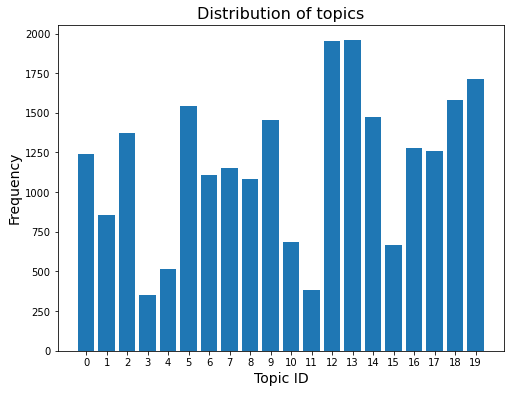

In [30]:
# Plot the topic distribution
plt.title("Distribution of topics")
plt.xlabel("Topic ID")
plt.ylabel("Frequency")
plt.bar(topics, counts, align = 'center')
plt.gca().set_xticks(topics)
plt.show()